# Import and Export Data for Santa Catarina

We want to answer the folowing questions:

* What are the top 3 most exported products by State since 2015?
* What are the top 3 most imported products by State since 2015?
* What are the top 3 most exported products in each month of last year by State?
* What is the percentage of total national exports by State last year?
* What is the percentage of total national imports by State last year?
* Prediction of value of top 3 exported products by month from Santa Catarina to each target Country.
* Prediction of value of top 3 imported products by month from Santa Catarina from each source Country.

## Contents





## Data Wrangling for Exports

First step to address our analysis will be to download the files, unzip them, clean them and finally organize the best way possible. I have decided to store the link to the government website and download it as we execute the notebook instead of uploading the file as Git LFS because those file locations **should not** change at all. Considering we are betting on the Brazilian government efficiency, we will store the MD5 of the used files "just in case" they ever change for any reason. One faster way to do this is simply download the zip files yourself and put them in the data folder.

In [11]:
#imports
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import os
import asyncio
import hashlib
import base64
import zipfile
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='once')


In [13]:
#download files (have patience young padawan...)
async def download_to_data_folder(file_url:str)->str:
    local_filename = 'data/'+file_url.split('/')[-1]
    with requests.get(file_url, stream=True, verify=False) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            downloaded = 0
            for chunk in r.iter_content(chunk_size=32768): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    downloaded += 32768
                    print(file_url.split('/')[-1]+'  '+str(downloaded),end='\r')
    return local_filename

async def download_all_files()->list:
    request_list = []
    request_list.append(download_to_data_folder('https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/EXP_COMPLETA.zip'))
    request_list.append(download_to_data_folder('https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip'))
    return asyncio.gather(*request_list)

if not os.path.exists('data/EXP_COMPLETA.zip'):
    file_list = await download_all_files()

_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=SSLError(MaxRetryError("HTTPSConnectionPool(host='balanca.economia.gov.br', port=443): Max retries exceeded with url: /balanca/bd/comexstat-bd/ncm/EXP_COMPLETA.zip (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1125)')))"))>
Traceback (most recent call last):
  File "/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 382, in _make_request
    self._validate_conn(conn)
  File "/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1010, in _validate_conn
    conn.connect()
  File "/Users/ashi

In [14]:
#unzip files
for file in os.listdir('data/'):
    print(file)
    if file[-3:] == 'zip':
        if not os.path.exists('data/'+file[:-3]+'csv'):
            with zipfile.ZipFile('data/'+file,"r") as zip_ref:
                zip_ref.extractall("data/")
                print('Extracted '+file)

EXP_COMPLETA.zip
Extracted EXP_COMPLETA.zip
IMP_COMPLETA.zip
Extracted IMP_COMPLETA.zip
.ipynb_checkpoints


We start with exports. One important point we notice are the file sizes. One has around 1.5G unzipped, the other has 2.15G. Those may be a problem for python if you are using a computer with less than 8G RAM Memory.

Let´s import the first one.

In [31]:
exp_df = pd.read_csv('data/EXP_COMPLETA.csv', delimiter=';')

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


We will replace the names with more human friendly ones, and we notice that some of the data is using codes like integers, not in a human friendly naming system. Those will have to be addressed as well. Reading the documentation in http://www.mdic.gov.br/index.php/comercio-exterior/estatisticas-de-comercio-exterior/base-de-dados-do-comercio-exterior-brasileiro-arquivos-para-download , we can download the missing tables and change our data to a more friendly one.

First thing I learned was what FOB means! https://www.ipea.gov.br/desafios/index.php?option=com_content&view=article&id=2115:catid=28&Itemid=23

So, the column VL_FOB should be renamed to Amount(USD). We also need to download the remaining tables with more human friendly definitions so we get our final Dataframe. Another impotant aspect to notice is that we will only need data from 2017 - 2019, so we will filter those in order to spare some memory space.




In [32]:
#Filtering years
exp_df.query('CO_ANO in [2015,2016,2017,2018,2019,2020,2021]',inplace=True)


In [33]:
exp_df.head(10)

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
15798116,2015,6,85369090,11,97,RO,9,250151,10,0,4
15798117,2015,6,84831019,11,845,MG,1,817800,3,29,147
15798118,2015,6,39072090,10,850,SP,1,817800,14440,14440,118408
15798119,2015,6,61099000,11,399,MG,4,817600,9,2,515
15798120,2015,6,39202090,10,586,SP,7,910600,325,325,2355
15798121,2015,6,15159090,10,190,SP,1,817800,150,150,4538
15798122,2015,6,99997103,10,240,RJ,9,717600,0,0,7645
15798123,2015,6,84213100,11,160,SP,4,817600,81,5,474
15798124,2015,6,84339090,10,63,MN,4,817700,21,21,412
15798125,2015,6,69089000,15,607,SC,1,927800,1865,47512,20425


In [34]:
exp_df.columns

Index(['CO_ANO', 'CO_MES', 'CO_NCM', 'CO_UNID', 'CO_PAIS', 'SG_UF_NCM',
       'CO_VIA', 'CO_URF', 'QT_ESTAT', 'KG_LIQUIDO', 'VL_FOB'],
      dtype='object')

In [35]:
async def download_missing_tables():
    request_list = []
    if not os.path.exists('data/PAIS.csv'):
        request_list.append(download_to_data_folder('https://balanca.economia.gov.br/balanca/bd/tabelas/PAIS.csv'))
    if not os.path.exists('data/VIA.csv'):
        request_list.append(download_to_data_folder('https://balanca.economia.gov.br/balanca/bd/tabelas/VIA.csv'))
    if not os.path.exists('data/NCM.csv'):
        request_list.append(download_to_data_folder('https://balanca.economia.gov.br/balanca/bd/tabelas/NCM.csv'))
    if len(request_list)>0:
        return asyncio.gather(*request_list)
    else:
        return None

await download_missing_tables()

In [36]:
pais_df = pd.read_csv('data/PAIS.csv', delimiter=';', encoding="latin-1")
via_df = pd.read_csv('data/VIA.csv', delimiter=';', encoding="latin-1")
produto_df = pd.read_csv('data/NCM.csv', delimiter=';', encoding="latin-1")


/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [37]:
pais_df.head(5)

,CO_PAIS,CO_PAIS_ISON3,CO_PAIS_ISOA3,NO_PAIS,NO_PAIS_ING,NO_PAIS_ESP
0,0,898,ZZZ,Não Definido,Not defined,No definido
1,13,4,AFG,Afeganistão,Afghanistan,Afganistan
2,15,248,ALA,"Aland, Ilhas",Aland Islands,"Alans, Islas"
3,17,8,ALB,Albânia,Albania,Albania
4,20,724,ESP,"Alboran-Perejil, Ilhas","Alboran-Perejil, Islands","Alboran-Perejil, Islas"


In [38]:
via_df.head(5)

,CO_VIA,NO_VIA
0,99,VIA DESCONHECIDA
1,13,POR REBOQUE
2,11,COURIER
3,15,VICINAL FRONTEIRICO
4,14,DUTOS


In [39]:
produto_df.head(5)

,CO_NCM,CO_UNID,CO_SH6,CO_PPE,CO_PPI,CO_FAT_AGREG,CO_CUCI_ITEM,CO_CGCE_N3,CO_SIIT,CO_ISIC_CLASSE,CO_EXP_SUBSET,NO_NCM_POR,NO_NCM_ESP,NO_NCM_ING
0,38085910,10,380859,3293,3293,3,5919,322,2000,2021,1499.0,Outras mercadorias mencionadas na Nota de subp...,Otros productos mencionados en la nota de sub...,Other commodities mentioned in Note of subhead...
1,38085921,10,380859,3293,3293,3,5919,240,2000,2021,1499.0,Mercadorias à base de metamidofós (ISO) ou mon...,Productos basados en metamidofos (ISO) o monoc...,Commodities based on methamidophos (ISO) or mo...
2,38085922,10,380859,3293,3293,3,5919,240,2000,2021,1499.0,"Mercadorias à base de endossulfan (ISO), apres...","Productos sobre la base de endosulfán (ISO), p...","Commodities based on endosulfan (ISO), present..."
3,38085923,10,380859,3293,3293,3,5919,322,2000,2021,1499.0,"Mercadorias à base de alaclor (ISO), apresenta...","Productos sobre la base de alaclor (ISO), pres...","Commodities based on alachlor (ISO), presented..."
4,38085929,10,380859,3293,3293,3,5919,240,2000,2021,1499.0,"Mercadorias à base de outras substâncias, apre...",Las mercancías sobre la base de otras sustanci...,"Commodities based on other substances, present..."


In [40]:
def adjust_main_df(df):
    df = df.merge(pais_df,how='inner',on='CO_PAIS')
    df = df.merge(via_df,how='inner',on='CO_VIA')
    df = df.merge(produto_df,how='inner',on=['CO_NCM','CO_UNID'])
    
    df.drop([
        'CO_PAIS',
        'QT_ESTAT',
        'CO_PAIS_ISON3',
        'NO_PAIS_ING',
        'CO_PAIS_ISOA3',
        'NO_PAIS_ESP',
        'CO_NCM',
        'CO_UNID',
        'CO_VIA',
        'CO_URF',
        'CO_PPI',
        'CO_FAT_AGREG',
        'CO_CUCI_ITEM',
        'CO_CGCE_N3',
        'CO_SIIT',
        'CO_EXP_SUBSET',
        'NO_NCM_ESP',
        'NO_NCM_ING',
        'CO_SH6',
        'CO_PPE'
    ],axis=1,inplace=True)
    
    df.rename(
        columns={
            "CO_ANO":"Ano",
            "VL_FOB":"Amount(USD)",
            "KG_LIQUIDO":"Kg",
            "SG_UF_NCM":"Estado",
            "CO_MES":"Mes",
            "NO_VIA":"Via",
            "NO_PAIS":"Pais",
            "NO_NCM_POR":"Produto"
        },inplace=True)
    
    column_order = ['Ano','Mes','Estado','Pais','Via','Produto','Kg','Amount(USD)']
    
    df = df[column_order]
    
    return df

exp_df = adjust_main_df(exp_df)

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


After some manipulations and merging of Dataframes, we finally have the ideal Dataframe with all information we need in a more human friendly naming system.

Next thing is to check for NAs, but there should not be many because all our merging was done using inner joins (we discarded information that was missing in either tables).

In [41]:
exp_df.isna().sum()

Ano            0
Mes            0
Estado         0
Pais           0
Via            0
Produto        0
Kg             0
Amount(USD)    0
dtype: int64

In [42]:
exp_df.head(10)

,Ano,Mes,Estado,Pais,Via,Produto,Kg,Amount(USD)
0,2015,6,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",0,4
1,2015,5,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",2,49
2,2015,6,RS,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",0,51
3,2015,3,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",4,150
4,2015,7,GO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",0,32
5,2015,11,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",0,3
6,2015,10,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",4,47
7,2015,1,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",4,140
8,2015,7,RS,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",1,102
9,2015,7,RO,Bolívia,MEIOS PROPRIOS,"Outros aparelhos para interrupção, etc, para c...",0,3


We now check if States, Countries and Months are correct.

In [43]:
exp_df['Estado'].drop_duplicates()

0          RO
2          RS
4          GO
23         SP
68         MG
70         ND
76         SC
152        PR
213        RJ
220        MN
234        RE
252        BA
303        DF
616        SE
737        AM
1064       AL
1802       PE
2171       ES
3107       RN
4500       PB
5268       PA
5302       MA
5409       RR
6661       CE
12006      MS
12048      AC
25240      AP
25475      PI
40621      MT
94455      CB
234461     TO
2789291    ZN
Name: Estado, dtype: object

In [44]:
exp_df['Pais'].drop_duplicates()

0                               Bolívia
69                              Uruguai
72                                Japão
73                             Paraguai
212                               China
                       ...             
2243192                        Vaticano
2691519        Marianas do Norte, Ilhas
3006472                   Midway, Ilhas
6292226                        Toquelau
7121232    Heard e ilhas mcdonald, Ilha
Name: Pais, Length: 255, dtype: object

In [45]:
exp_df['Pais'].drop_duplicates().count()

255

In [46]:
exp_df['Mes'].drop_duplicates().sort_values()

7      1
14     2
3      3
15     4
1      5
0      6
4      7
11     8
13     9
6     10
5     11
10    12
Name: Mes, dtype: int64

It seems we will have to remove 4 States that do not exist (RE, ND, MN and CB), the rest seems all right.

In [47]:
exp_df = exp_df[(exp_df['Estado'] != 'MN')]
exp_df = exp_df[exp_df['Estado'] != 'CB']
exp_df = exp_df[exp_df['Estado'] != 'RE']
exp_df = exp_df[exp_df['Estado'] != 'ND']
exp_df = exp_df[exp_df['Estado'] != 'ZN']

## Analysing Exports

Next step in our analysis is to answer the first question: list the top 3 exports by estate in 2017, 2018 and 2019.

In [48]:
exp_grouped = exp_df.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped = exp_grouped.sort_values(by='Amount(USD)',ascending=False)
exp_grouped = exp_grouped.groupby(['Ano','Estado']).head(3)
exp_grouped = exp_grouped.sort_values(by=['Estado','Ano'],ascending=False)
exp_grouped.head(10)

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:214: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/releas

,Ano,Estado,Produto,Amount(USD)
59038,2016,ZN,"Outras ferramentas intercambiáveis, de metais ...",6359
59039,2016,ZN,"Outros mós de diamante natural ou sintético, a...",3672
59037,2016,ZN,"Engrenagens e rodas de fricção, eixos de esfer...",572
248346,2021,TO,"Soja, mesmo triturada, exceto para semeadura",1281501242
248293,2021,TO,"Carnes desossadas de bovino, congeladas",344486019
248307,2021,TO,"Milho em grão, exceto para semeadura",107755330
205245,2020,TO,"Soja, mesmo triturada, exceto para semeadura",871954730
205194,2020,TO,"Carnes desossadas de bovino, congeladas",306416896
205213,2020,TO,"Milho em grão, exceto para semeadura",120984859
164268,2019,TO,"Soja, mesmo triturada, exceto para semeadura",772631752


We have 26 States in Brazil, now we just have to find out how many different products we have to think about the best representation.

In [49]:
exp_grouped['Produto'].drop_duplicates().count()

83

In [50]:
exp_grouped['Produto'].drop_duplicates()

59038     Outras ferramentas intercambiáveis, de metais ...
59039     Outros mós de diamante natural ou sintético, a...
59037     Engrenagens e rodas de fricção, eixos de esfer...
248346         Soja, mesmo triturada, exceto para semeadura
248293              Carnes desossadas de bovino, congeladas
                                ...                        
205285          Castanha-do-pará, fresca ou seca, com casca
205384    Outras madeiras compensadas, constituídas excl...
164350    Madeiras tropicais perfilada (com espigas, ran...
164390    Outras miudezas comestíveis de bovino, congeladas
53        Outras madeiras compensadas, constituídas excl...
Name: Produto, Length: 83, dtype: object

The names are hard to understand and there are many similar products in different categories. For this reason, we will rename them and merge when necessary.

In [51]:
def get_name_dict():
    name_dict = {}
    name_dict['madeiras'] = "Madeira"
    name_dict['petróleo'] = "Petróleo"
    name_dict['Milho'] = "Milho"
    name_dict['Soja'] = "Soja"
    name_dict['bovino'] = "Carne Bovina"
    name_dict['açúcares'] = "Açúcar"
    name_dict['aviões'] = "Aviões"
    name_dict['Suco (sumo) de laranja'] = "Suco de Laranja"
    name_dict['calçados'] = "Calçados"
    name_dict['Calçados'] = "Calçados"
    name_dict['galos/galinhas'] = "Frango"
    name_dict['Tabaco'] = "Tabaco"
    name_dict['Plataforma de perfuração'] = "Maquinário"
    name_dict['Barcos'] = "Barcos"
    name_dict['Plataformas de perfuração'] = "Barcos"
    name_dict['suíno'] = "Suínos"
    name_dict['Automóveis'] = "Automóveis"
    name_dict['Motocicletas'] = "Automóveis"
    name_dict['Ouro'] = "Ouro"
    name_dict['Arroz'] = "Arroz"
    name_dict['madeira'] = "Madeira"
    name_dict['Castanha'] = "Castanha"
    name_dict['algodão'] = "Algodão"
    name_dict['Algodão'] = "Algodão"
    name_dict['turborreatores'] = "Maquinário"
    name_dict['Turborreatores'] = "Maquinário"
    name_dict['aparelhos para filtrar'] = "Maquinário"
    name_dict['máquinas automáticas'] = "Maquinário"
    name_dict['motores'] = "Maquinário"
    name_dict['ferro'] = "Ferro"
    name_dict['Ferro'] = "Ferro"
    name_dict['Aviões'] = "Aviões"
    name_dict['madeiras'] = "Madeira"
    name_dict['Madeira'] = "Madeira"
    name_dict['tereftalato'] = "Petróleo"
    name_dict['cobre'] = "Cobre"
    name_dict['oil'] = "Petróleo"
    name_dict['diesel'] = "Petróleo"
    name_dict['máquinas de medida'] = "Maquinário"
    name_dict['cloreto de vinila'] = "Petróleo"
    name_dict['Querosenes'] = "Petróleo"
    name_dict['Bulhão dourado'] = "Ouro"
    name_dict['barbear'] = "Aparelho barbear"
    name_dict['soja'] = "Soja"
    name_dict['Café'] = "Café"
    name_dict['Alumina'] = "Aluminio"
    name_dict['titânio'] = "Titanio"
    name_dict['Ladrilhos'] = "Material Construção"
    name_dict['elaboração de bebidas'] = "Bebidas"
    name_dict['estômagos'] = "Produtos Animais"
    name_dict['de laranja'] = "Laranja"
    name_dict['alumínio'] = "Alumínio"
    name_dict['de milho'] = "Milho"
    name_dict['Açúcar'] = "Açúcar"
    name_dict['soda cáustica'] = "Químicos"
    name_dict['Etileno'] = "Petróleo"
    name_dict['tabacos'] = "Tabaco"
    name_dict['Fios'] = "Fios"
    name_dict['Máquinas e aparelhos'] = "Maquinário"
    name_dict['radiodifusão'] = "Maquinário"
    name_dict['dispensadores'] = "Maquinário"
    name_dict['Outras frutas'] = "Frutas"
    name_dict['Sucos'] = "Sucos"
    name_dict['outras ligas de aço'] = "Ferro"
    name_dict['hulha'] = "Carvão"
    name_dict['gasolinas'] = "Petróleo"
    name_dict['veículos automóveis'] = "Automóveis"
    name_dict['Mangas'] = "Mangas"
    name_dict['Uvas'] = "Uvas"
    name_dict['abacaxi'] = "Abacaxi"
    name_dict['Mamões'] = "Mamão"
    name_dict['coco'] = "Côco"
    name_dict['lagostas'] = "Lagosta"
    name_dict['Granito'] = "Granito"
    name_dict['produtos de padaria'] = "Alimentícios"
    name_dict['Sal marinho'] = "Sal"
    name_dict['produtos de origem animal'] = "Produtos de animais"
    name_dict['Estanho'] = "Estanho"
    name_dict['lavagem e limpeza'] = "Produtos de Limpeza"
    name_dict['Estanho'] = "Estanho"
    name_dict['policloretos'] = "Químicos"
    name_dict['adesivos'] = "Químicos"
    name_dict['Pneumáticos'] = "Pneus"
    name_dict['cimento'] = "Material Construção"
    name_dict['pavimentos'] = "Material Construção"
    name_dict['amônio'] = "Químicos"
    name_dict['etileno'] = "Químicos"
    name_dict['naftas'] = "Químicos"
    name_dict['Alhos'] = "Alho"
    name_dict['telefonia'] = "Telefonia"
    name_dict['Processadores'] = "Eletrônicos"
    name_dict['trigos'] = "Trigo"
    name_dict['Hulha'] = "Carvão"
    name_dict['medicamentos'] = "Medicamentos"
    name_dict['Medicamento'] = "Medicamentos"
    name_dict['imunológico'] = "Medicamentos"
    name_dict['repetidores'] = "Informática"
    name_dict['Torneiras'] = "Material Construção"
    name_dict['Basiliximab'] = "Medicamentos"
    name_dict['cloretos de potássio'] = "Químicos"
    name_dict['Estanho'] = "Estanho"
    name_dict['Naftas'] = "Químicos"
    name_dict['Gás natural'] = "Gás"
    name_dict['etílico'] = "Alcool"
    name_dict['Outras máquinas'] = "Maquinário"
    name_dict['Outros adubos'] = "Adubo"
    name_dict['zinco'] = "Zinco"
    name_dict['Uréia'] = "Adubo"
    name_dict['Condensadores'] = "Maquinário"
    name_dict['Caldeiras'] = "Maquinário"
    name_dict['ar condicionado'] = "Eletrônicos"
    name_dict['microprocessamento'] = "Eletrônicos"
    name_dict['Ureia'] = "Adubo"
    name_dict['Células solares'] = "Célula solar"
    name_dict['conversores elétricos'] = "Maquinário"
    name_dict['pneumáticos'] = "Pneus"
    name_dict['microprocessadores'] = "Eletrônicos"
    name_dict['Polipropileno'] = "Plástico"
    name_dict['armações de óculos'] = "Armação de Óculos"
    return name_dict

def get_category(line, name_dict):
    for keyword in name_dict.keys():
        if keyword in line:
            return name_dict[keyword]
    return line



In [52]:
name_dict = get_name_dict()
exp_grouped['Produto'] = exp_grouped['Produto'].apply(lambda x: get_category(x,name_dict))
exp_grouped.reset_index(inplace=True, drop=True)
exp_grouped.head(10)

,Ano,Estado,Produto,Amount(USD)
0,2016,ZN,"Outras ferramentas intercambiáveis, de metais ...",6359
1,2016,ZN,"Outros mós de diamante natural ou sintético, a...",3672
2,2016,ZN,"Engrenagens e rodas de fricção, eixos de esfer...",572
3,2021,TO,Soja,1281501242
4,2021,TO,Carne Bovina,344486019
5,2021,TO,Milho,107755330
6,2020,TO,Soja,871954730
7,2020,TO,Carne Bovina,306416896
8,2020,TO,Milho,120984859
9,2019,TO,Soja,772631752


Now we have another problem: due to the renaming, two different products in our original table might have become one single product. For an example: soy beans and soy flour are now just Soy. For this reason, we have to make another groupby and sum.

In [53]:
exp_grouped = exp_grouped.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped['Amount(USD)'] = exp_grouped['Amount(USD)'].apply(lambda x: x/1000000)
exp_grouped.head(10)

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:214: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/releas

,Ano,Estado,Produto,Amount(USD)
0,2015,AC,Castanha,10.587069
1,2015,AC,Madeira,1.762367
2,2015,AL,Açúcar,469.160008
3,2015,AL,Maquinário,170.600922
4,2015,AM,Aparelho barbear,44.683231
5,2015,AM,Automóveis,106.472582
6,2015,AM,Bebidas,274.835979
7,2015,AP,Frutas,28.408103
8,2015,AP,Madeira,59.010733
9,2015,AP,Ouro,149.564039


/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


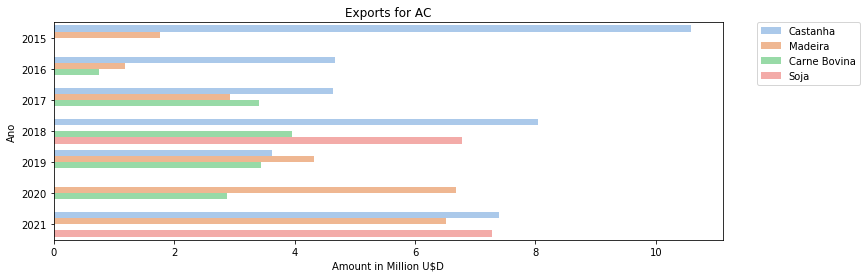

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


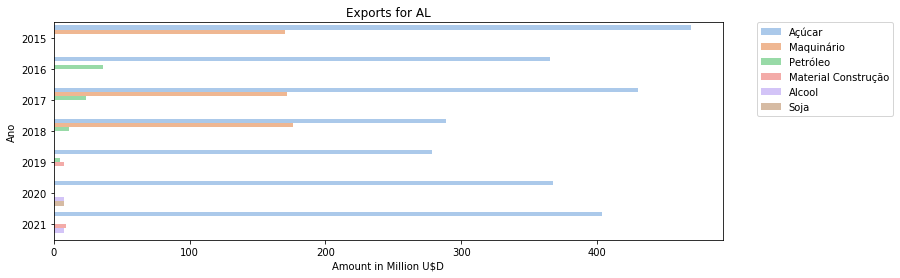

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


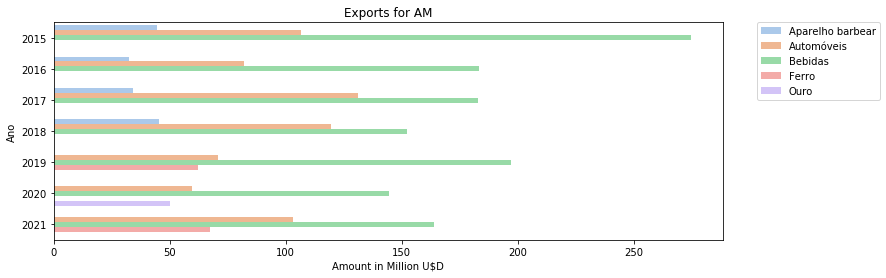

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


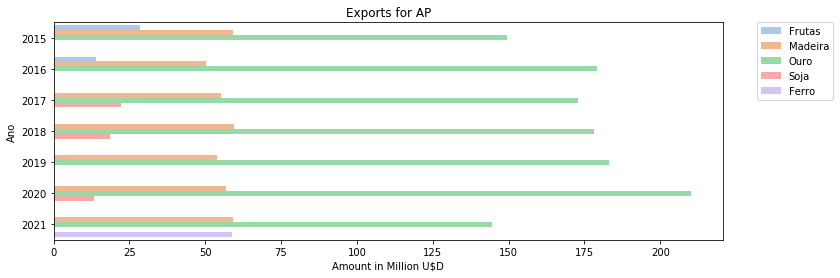

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


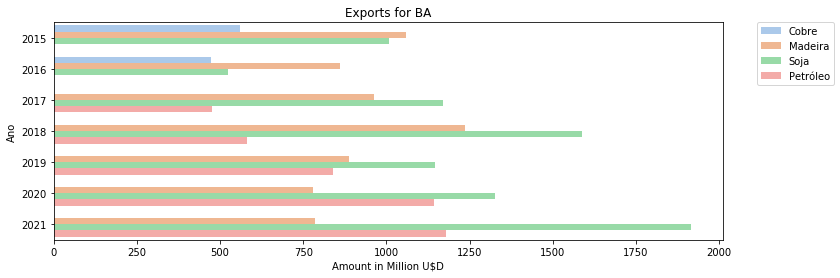

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


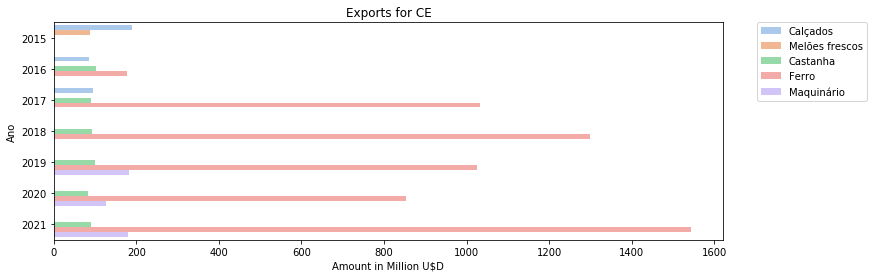

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


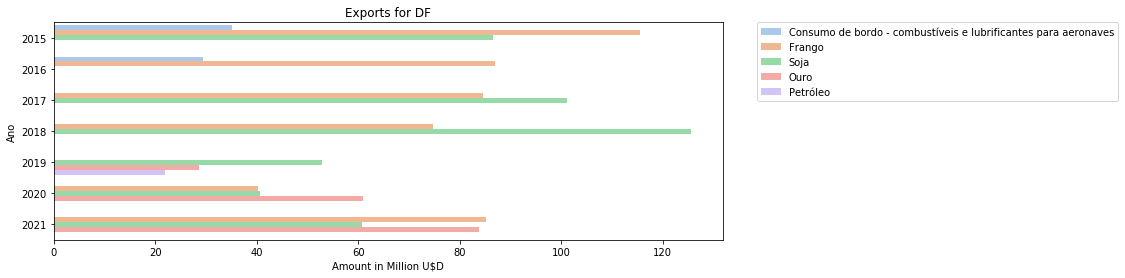

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


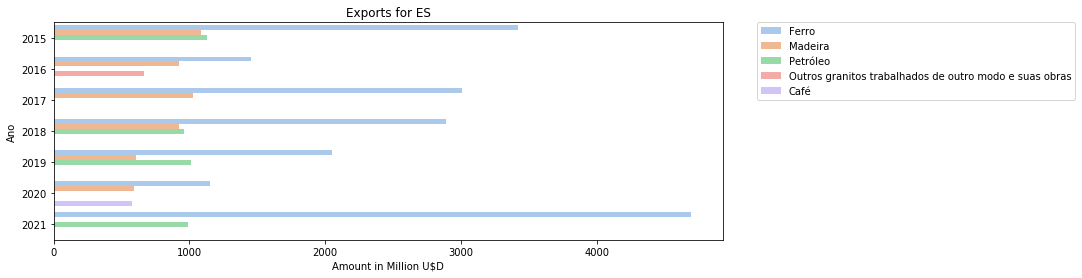

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


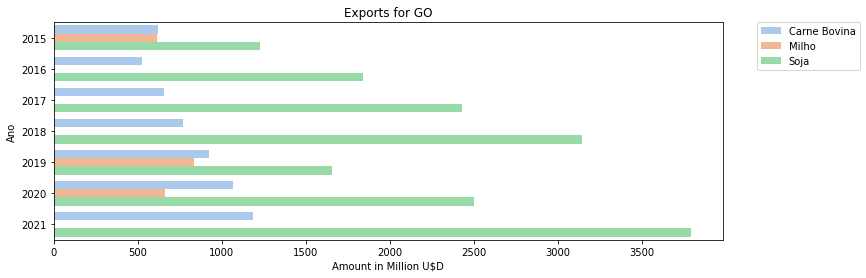

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


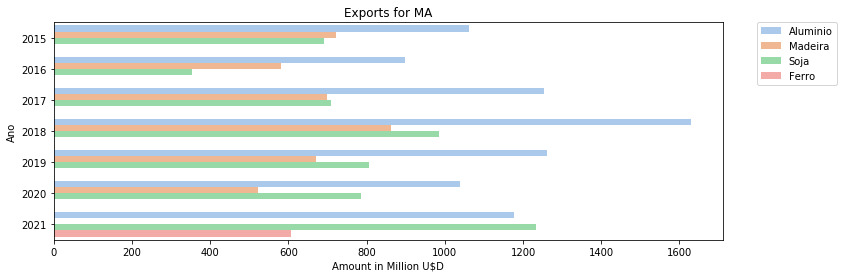

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


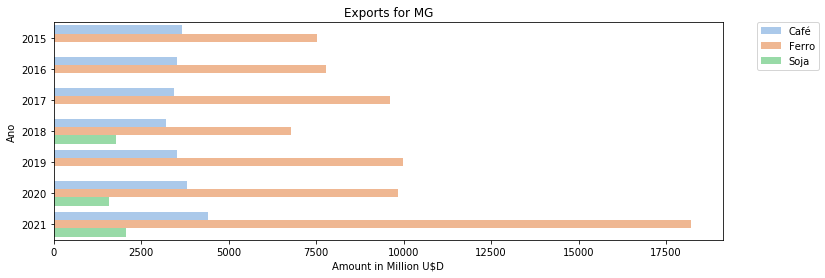

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


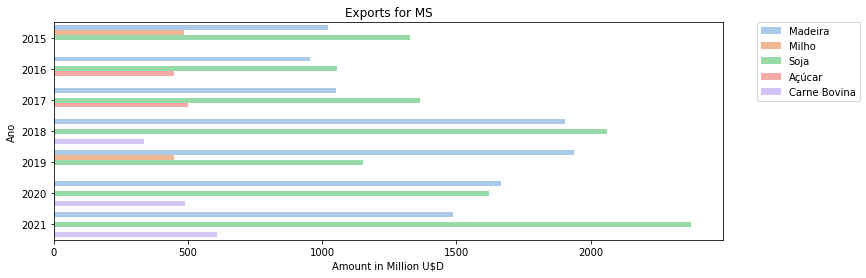

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


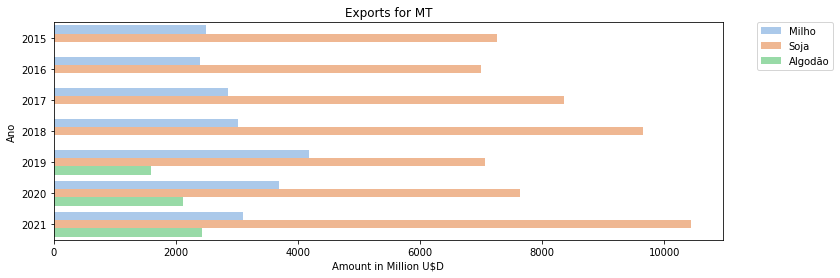

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


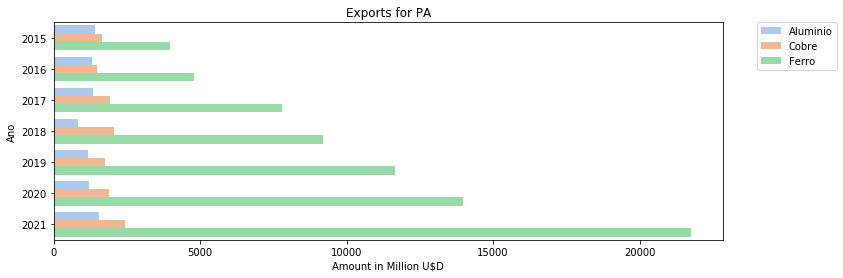

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


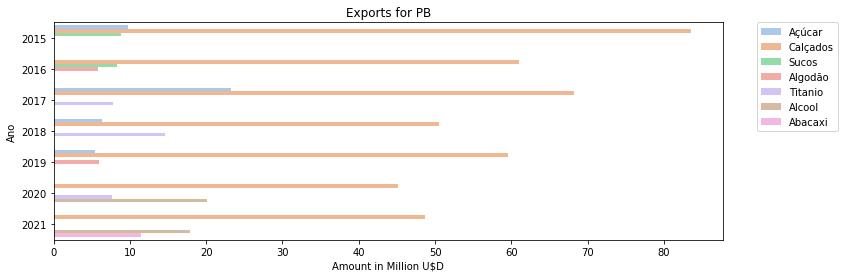

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


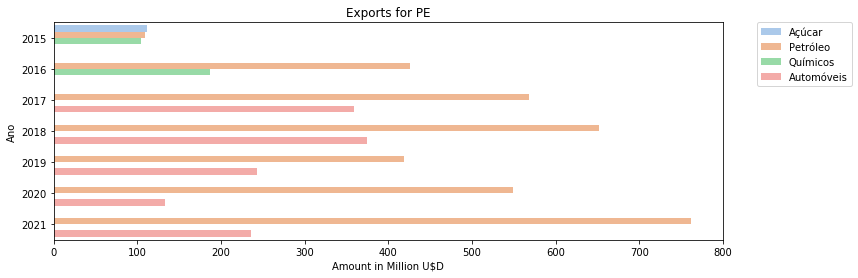

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


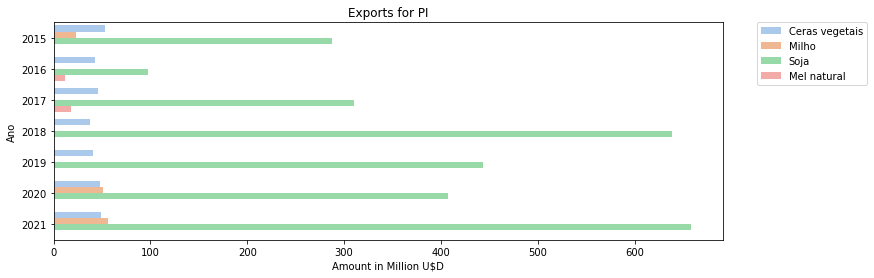

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


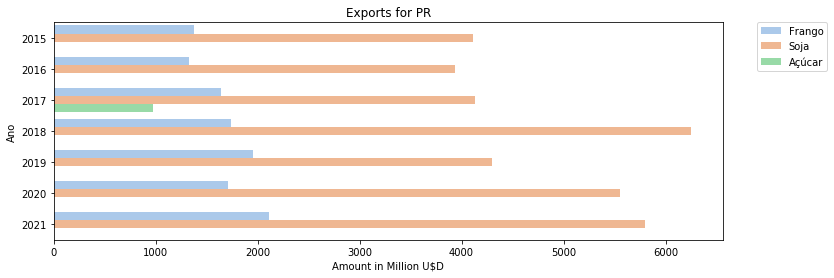

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


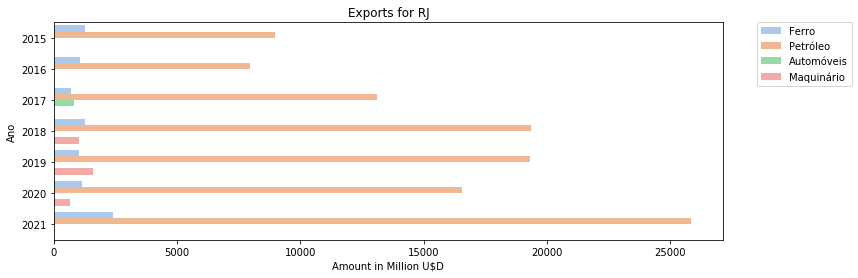

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


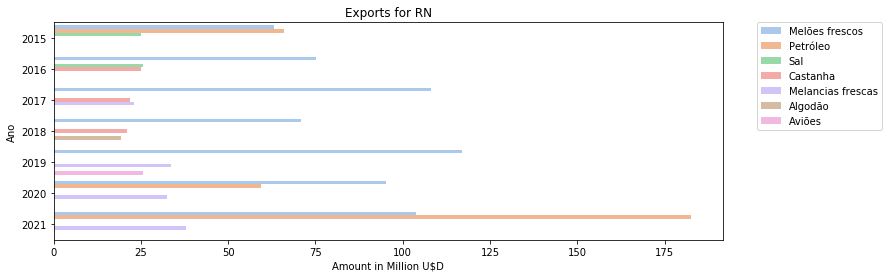

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


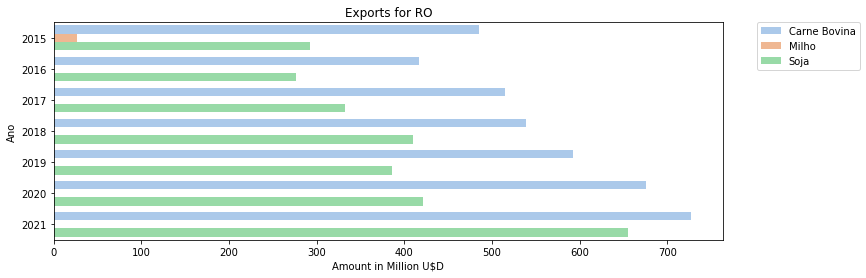

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


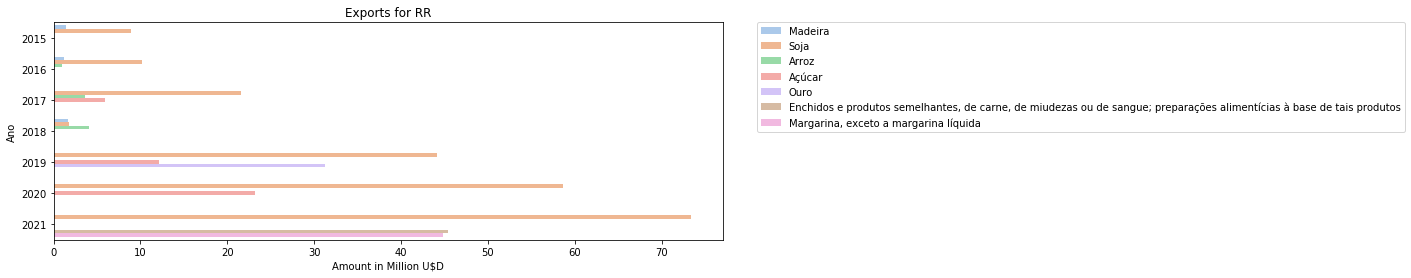

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


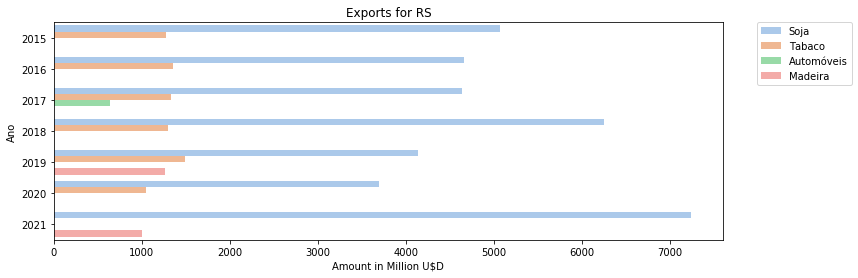

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


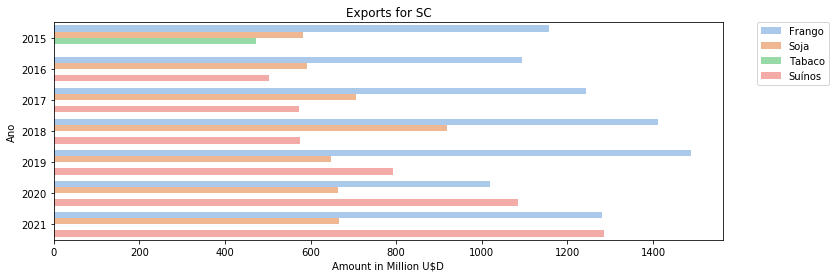

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


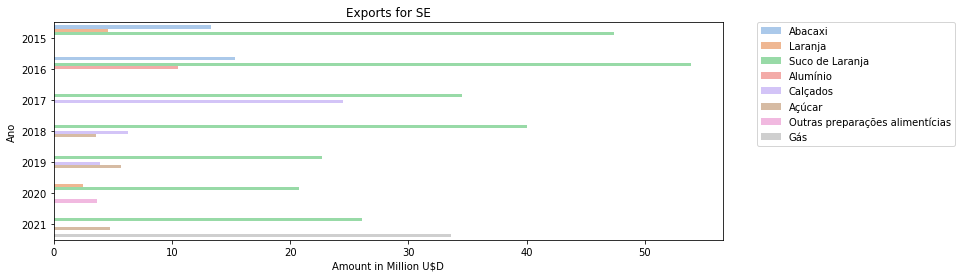

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


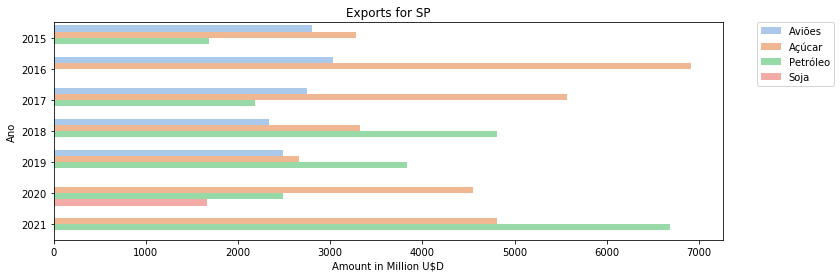

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


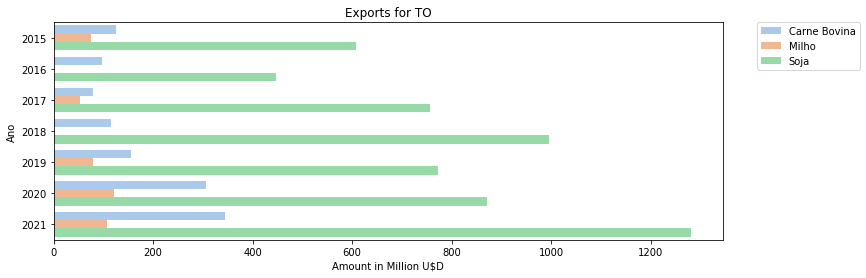

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


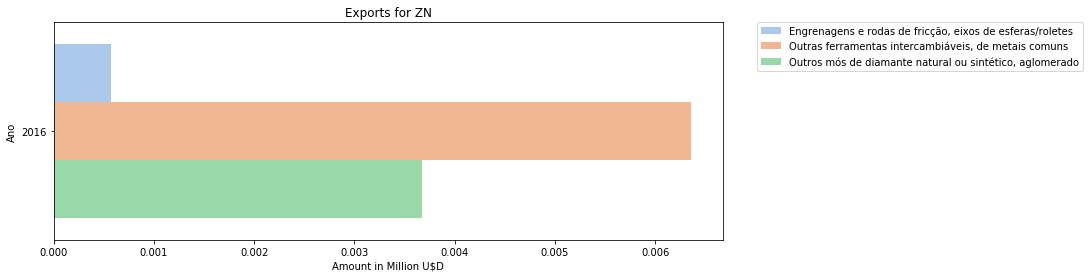

In [54]:
state_list = exp_grouped['Estado'].drop_duplicates().tolist()

for i,state in enumerate(state_list):
    fig = plt.figure(i,figsize=(12,4))
    
    ax = sns.barplot(
        x="Amount(USD)", 
        y="Ano",
        data=exp_grouped[exp_grouped['Estado']==state], 
        hue="Produto", 
        orient="h", 
        palette='pastel')
    ax.set_title('Exports for '+state)
    ax.set(xlabel='Amount in Million U$D')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('img/export_year_'+state+'.png', format='png', bbox_inches='tight', pad_inches=0.5)
    show_this = plt.show()
    plt.close(fig)


We notice some States had only 2 exports, and this means that after the name change to make visualization easier, two products merged into one. 

In [55]:

exp_grouped = exp_df[exp_df['Ano']==2019].groupby(['Ano','Mes','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped = exp_grouped.sort_values(by='Amount(USD)',ascending=False)
exp_grouped = exp_grouped.groupby(['Ano','Mes','Estado']).head(3)
exp_grouped = exp_grouped.sort_values(by=['Estado','Mes','Ano'],ascending=False)
exp_grouped.reset_index(inplace=True)
exp_grouped['Produto'] = exp_grouped['Produto'].apply(lambda x: get_category(x,name_dict))
exp_grouped = exp_grouped.groupby(['Ano','Mes','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
exp_grouped['Amount(USD)'] = exp_grouped['Amount(USD)'].apply(lambda x: x/1000000)
exp_grouped.head(10)

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:214: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/releas

,Ano,Mes,Estado,Produto,Amount(USD)
0,2019,1,AC,Castanha,0.851810
1,2019,1,AC,Madeira,1.058690
2,2019,1,AL,Açúcar,25.985334
3,2019,1,AL,Químicos,1.806044
4,2019,1,AM,Bebidas,14.425511
5,2019,1,AM,Ferro,7.253337
6,2019,1,AM,Soja,7.677952
7,2019,1,AP,Frutas,0.484047
8,2019,1,AP,Madeira,2.761465
9,2019,1,AP,Ouro,16.900377


/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


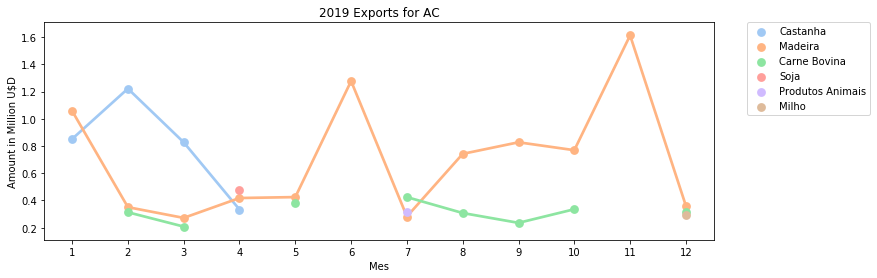

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


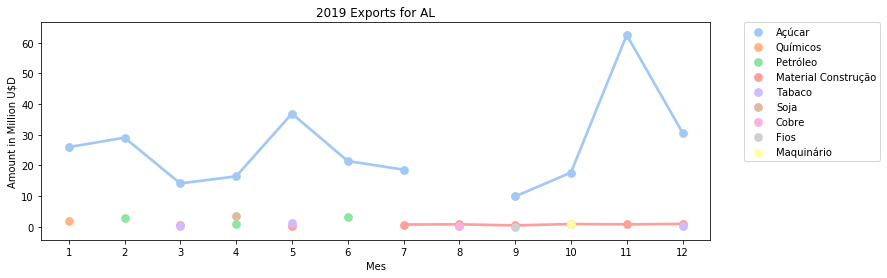

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


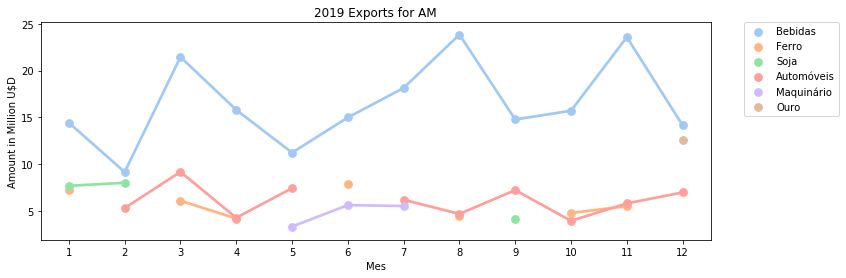

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


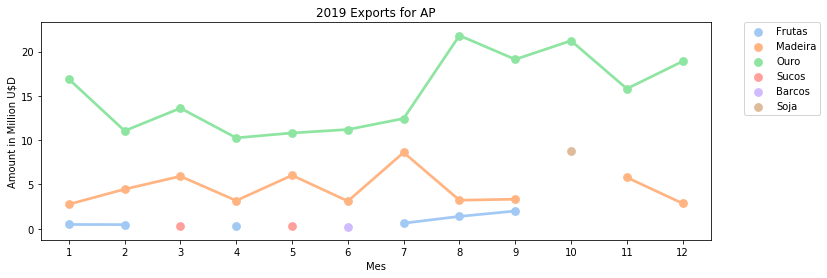

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


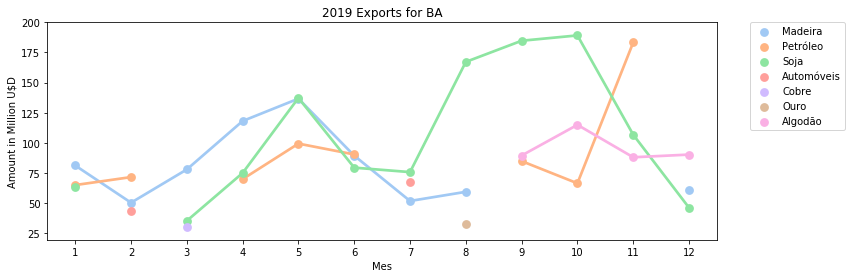

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


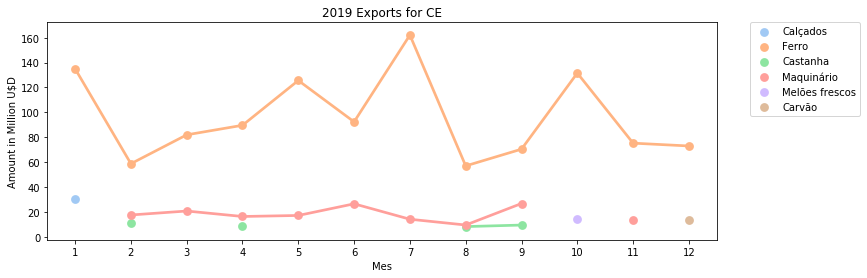

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


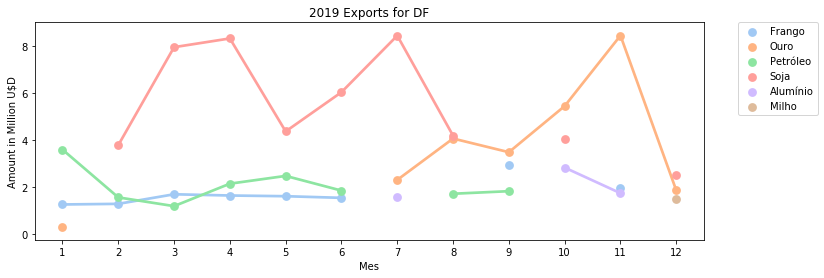

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


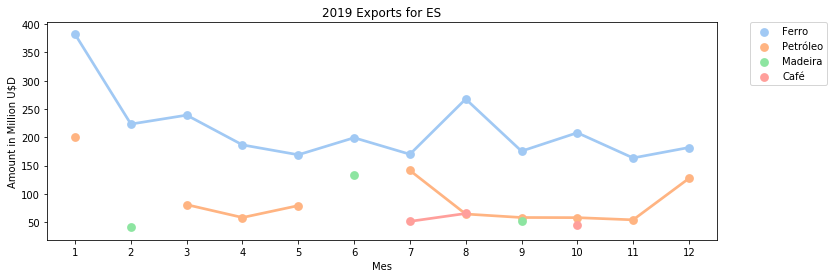

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


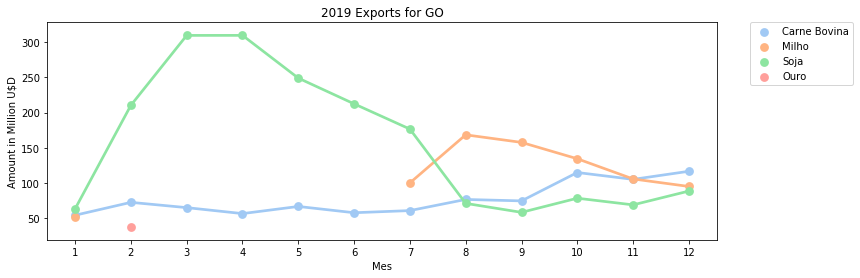

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


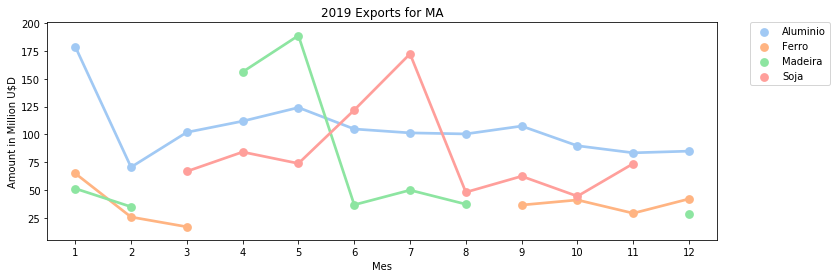

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


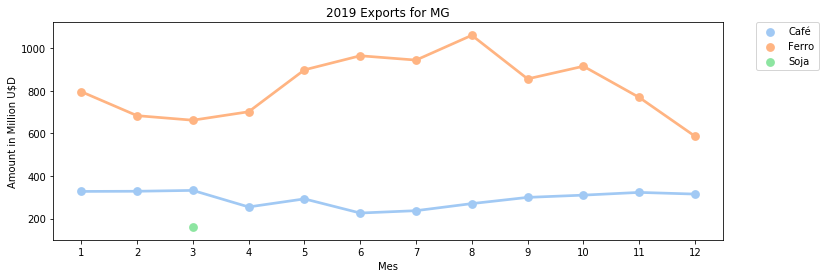

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


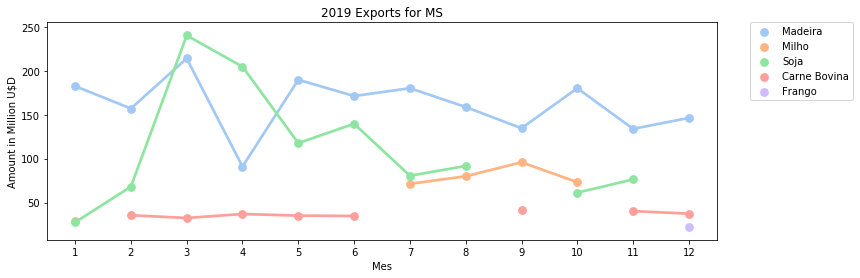

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


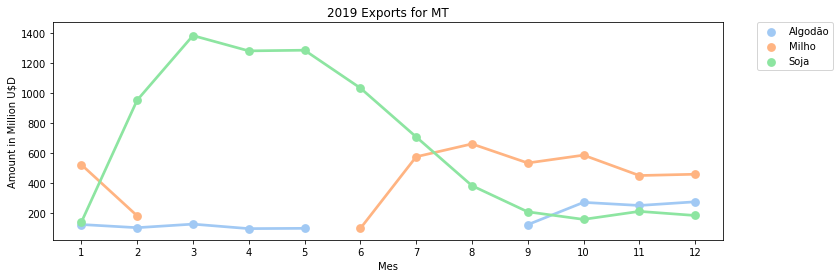

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


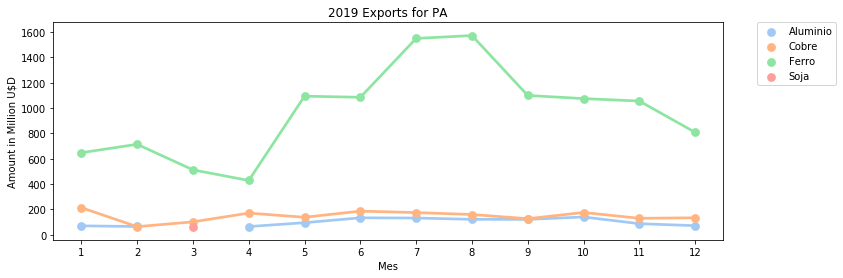

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


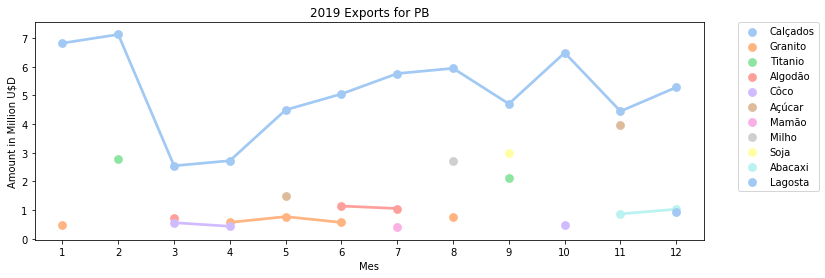

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


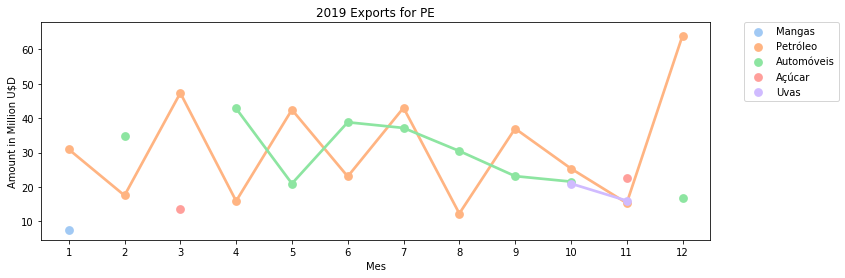

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


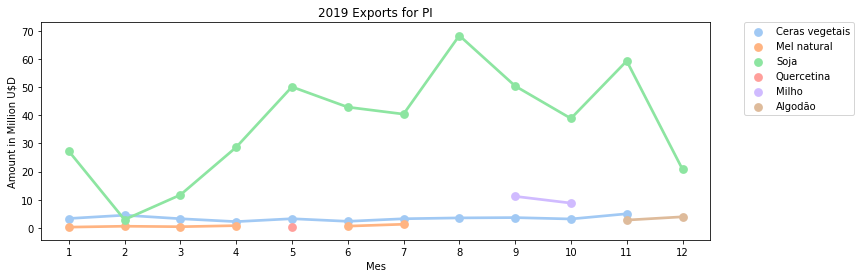

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


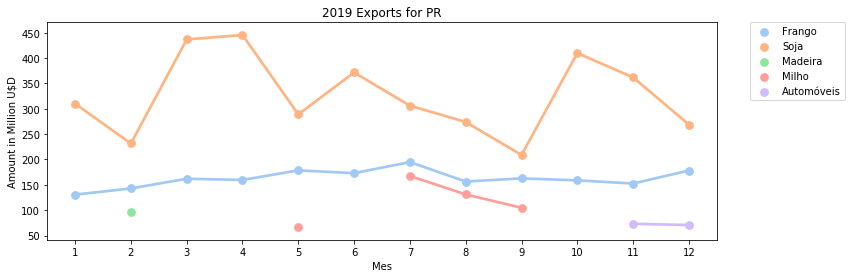

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


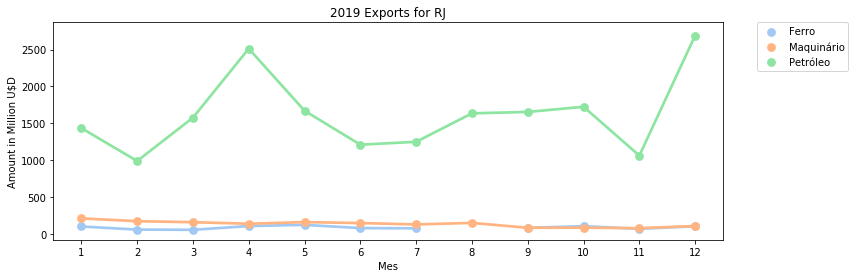

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


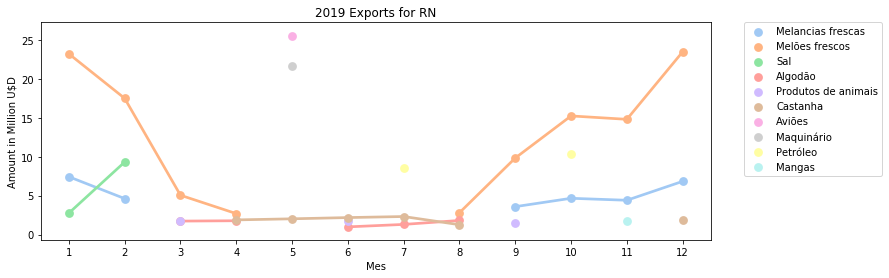

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


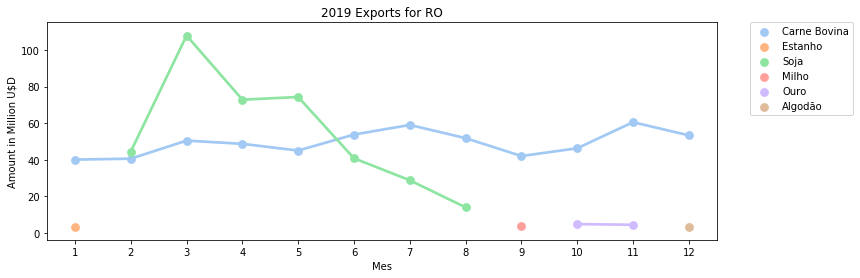

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


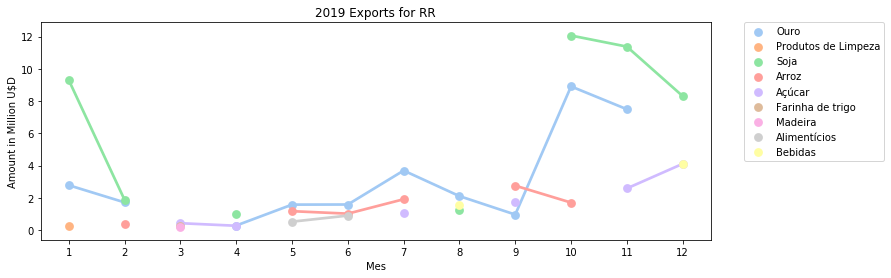

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


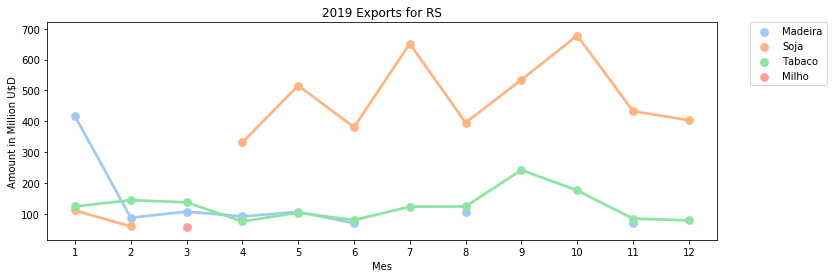

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


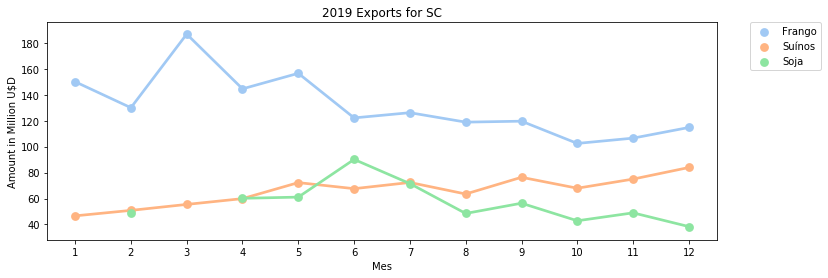

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


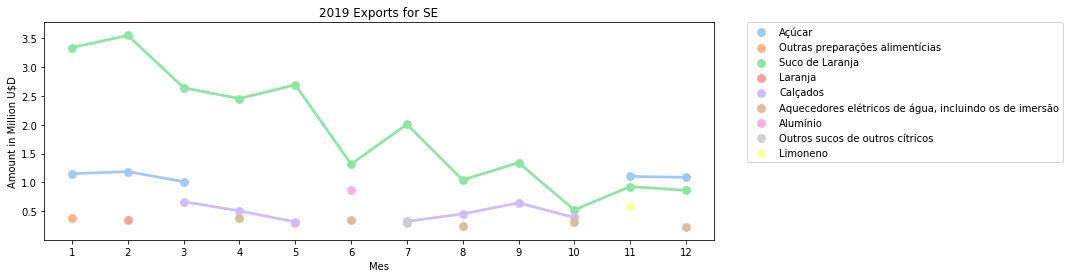

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


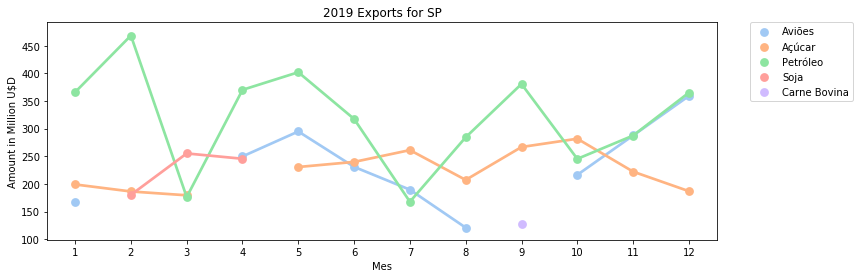

/Users/ashimono/Projects/Weblogiko/data_science/venv/lib/python3.8/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


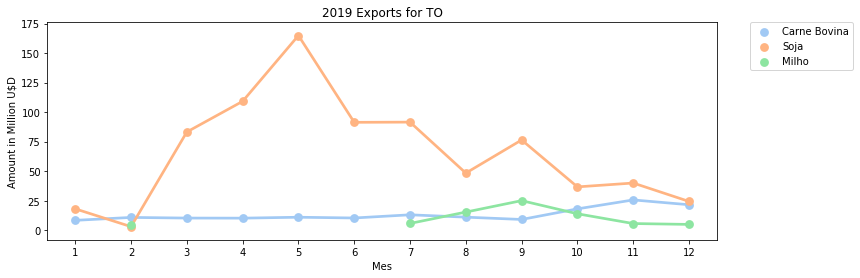

In [56]:
state_list = exp_grouped['Estado'].drop_duplicates().tolist()
for i,state in enumerate(state_list):
    fig = plt.figure(i,figsize=(12,4))
    ax = sns.pointplot(
        x="Mes", 
        y="Amount(USD)",
        data=exp_grouped[exp_grouped['Estado']==state], 
        hue="Produto", 
        orient="v", 
        palette='pastel')
    ax.set_title('2019 Exports for '+state)
    ax.set(ylabel='Amount in Million U$D')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('img/export_month_'+state+'.png', format='png', bbox_inches='tight', pad_inches=0.5)
    show_this = plt.show()
    plt.close(fig)


In [57]:
exp_grouped['Produto'].drop_duplicates().count()

56

In [27]:
exp_grouped = exp_df[exp_df['Ano']==2019].groupby(['Ano','Estado'], as_index=False)['Amount(USD)'].sum()
exp_grouped.head(10)

,Ano,Estado,Amount(USD)
0,2019,AC,32853291
1,2019,AL,319088835
2,2019,AM,731091968
3,2019,AP,261368366
4,2019,BA,8168158116
5,2019,CE,2275188077
6,2019,DF,160701336
7,2019,ES,8800321849
8,2019,GO,7133398211
9,2019,MA,3543622779


In [28]:
total_sum = exp_grouped['Amount(USD)'].sum()
print(total_sum)

223446289725


In [29]:
exp_grouped['percentage'] = exp_grouped.apply(lambda x: (x['Amount(USD)'] / total_sum) * 100, axis=1)
exp_grouped = exp_grouped.sort_values(by='percentage',ascending=False)
exp_grouped.head(10)

,Ano,Estado,Amount(USD),percentage
25,2019,SP,48852560073,21.863223
18,2019,RJ,28634458633,12.814918
10,2019,MG,25138578745,11.250390
22,2019,RS,18545065307,8.299563
13,2019,PA,17841239155,7.984576
12,2019,MT,17206103910,7.700331
17,2019,PR,16454197120,7.363827
23,2019,SC,8951838846,4.006260
7,2019,ES,8800321849,3.938451
4,2019,BA,8168158116,3.655535


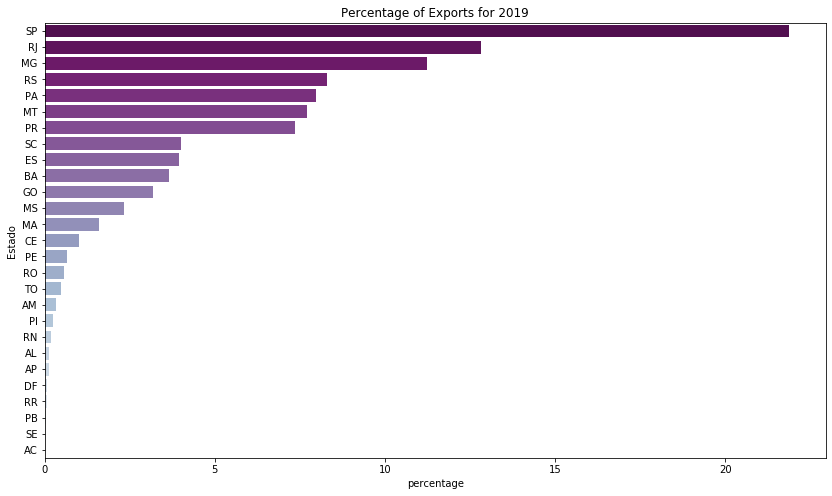

In [30]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="percentage", y="Estado",data=exp_grouped, palette="BuPu_r")
ax.set_title("Percentage of Exports for 2019")
plt.savefig('img/export_percentage_2019.png', format='png', bbox_inches='tight', pad_inches=0.5)
plt.show()

## Data Wrangling for Imports

Now we load and handle the imports file.

In [43]:
imp_df = pd.read_csv('data/IMP_COMPLETA.csv', delimiter=';')
imp_df = adjust_main_df(imp_df)

In [44]:
imp_df.isna().sum()

Ano            0
Mes            0
Estado         0
Pais           0
Via            0
Produto        0
Kg             0
Amount(USD)    0
dtype: int64

In [45]:
imp_df['Estado'].drop_duplicates()

0        RS
1        RJ
2        SC
8        SP
76       PR
365      MS
779      MG
1261     BA
1275     GO
1319     ES
1413     SE
1511     PA
1548     PE
1581     RN
2014     MT
2077     DF
2198     ZN
2215     AM
2245     PB
2299     CE
2493     RO
2546     PI
3040     AL
3500     MA
3764     TO
3942     RR
5342     AP
27935    AC
Name: Estado, dtype: object

In [35]:
imp_df = imp_df[imp_df['Estado'] != 'ZN']
imp_df['Pais'].drop_duplicates()

0                                 Japão
242                              França
244                             Áustria
248                               China
612                            Alemanha
                       ...             
3081654                            Togo
3092881                      Wake, Ilha
3231069            São Pedro e Miquelon
3650893    Heard e ilhas mcdonald, Ilha
5544590                       Antártica
Name: Pais, Length: 250, dtype: object

## Imports Analysis
Now it is time to analyse our imports.

In [36]:
imp_grouped = imp_df.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
imp_grouped = imp_grouped.sort_values(by='Amount(USD)',ascending=False)
imp_grouped = imp_grouped.groupby(['Ano','Estado']).head(3)
imp_grouped = imp_grouped.sort_values(by=['Estado','Ano'],ascending=False)
imp_grouped.head(10)
name_dict = get_name_dict()
imp_grouped['Produto'] = imp_grouped['Produto'].apply(lambda x: get_category(x,name_dict))
imp_grouped.reset_index(inplace=True, drop=True)
imp_grouped = imp_grouped.groupby(['Ano','Estado','Produto'], as_index=False)['Amount(USD)'].sum()
imp_grouped['Amount(USD)'] = imp_grouped['Amount(USD)'].apply(lambda x: x/1000000)
imp_grouped.head(10)

,Ano,Estado,Produto,Amount(USD)
0,2017,AC,Alho,0.393150
1,2017,AC,Castanha,0.235580
2,2017,AC,Químicos,0.293144
3,2017,AL,Algodão,35.044473
4,2017,AL,Alho,36.706566
5,2017,AL,Químicos,19.865314
6,2017,AM,Eletrônicos,397.652474
7,2017,AM,Maquinário,1824.483948
8,2017,AM,Telefonia,600.288454
9,2017,AP,Carvão,6.622802


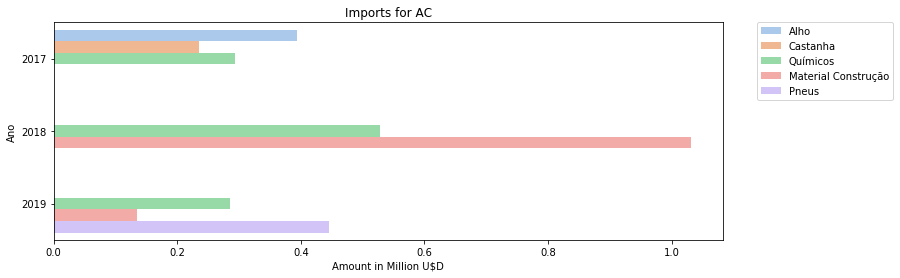

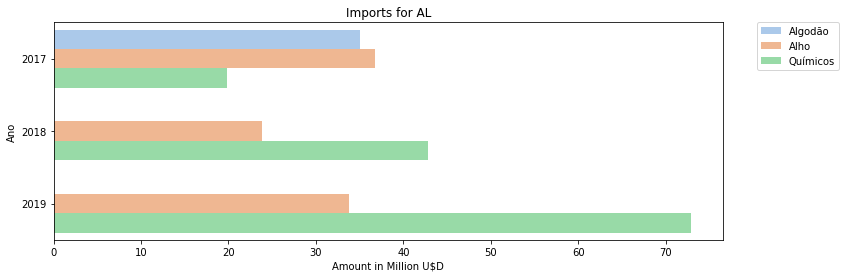

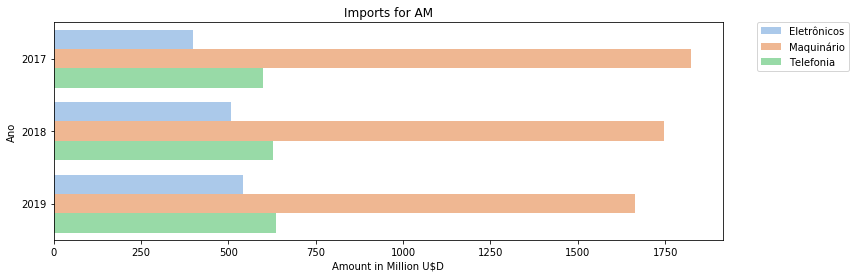

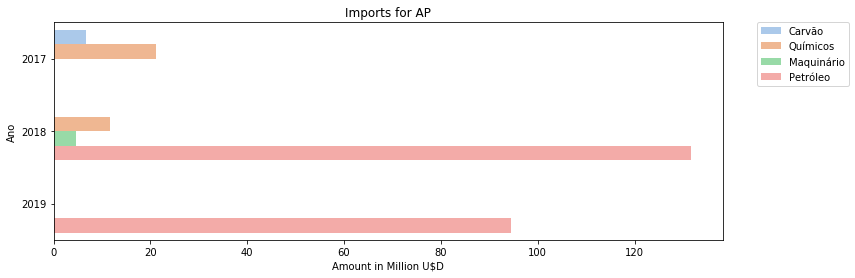

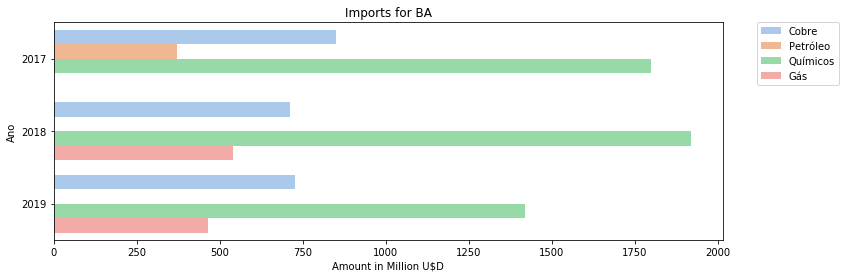

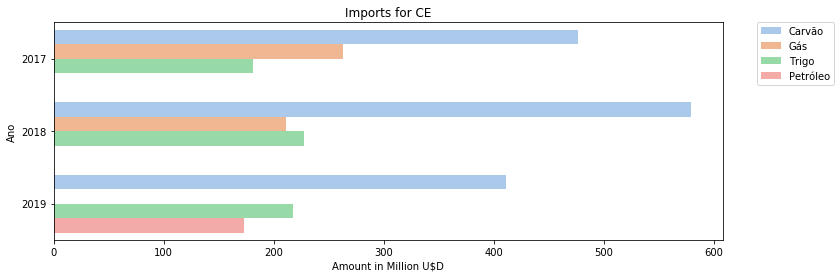

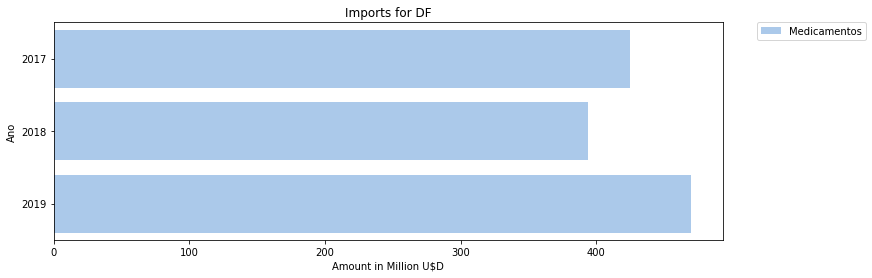

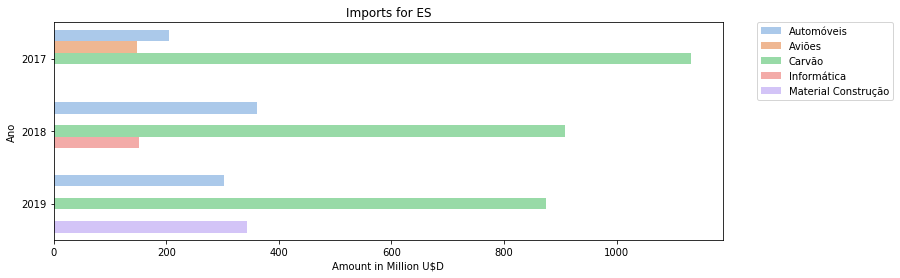

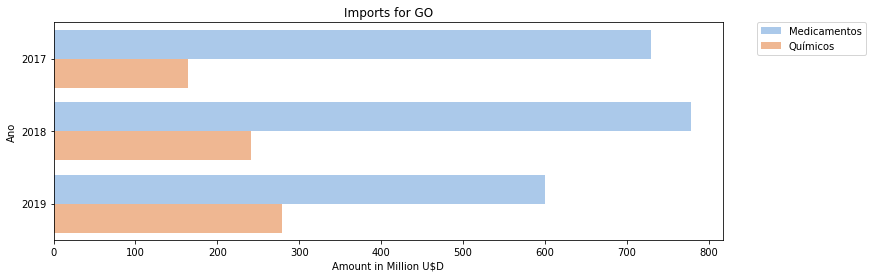

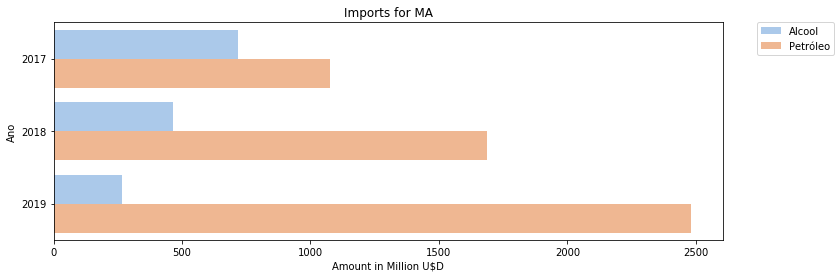

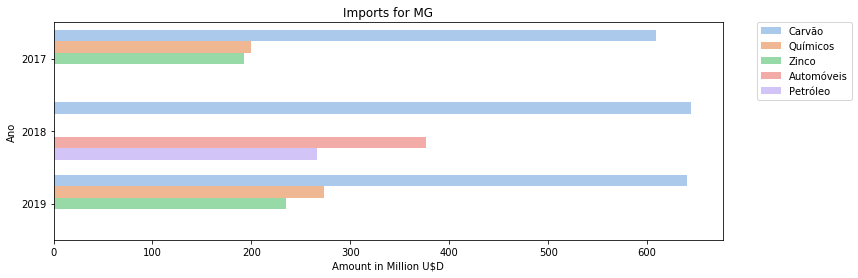

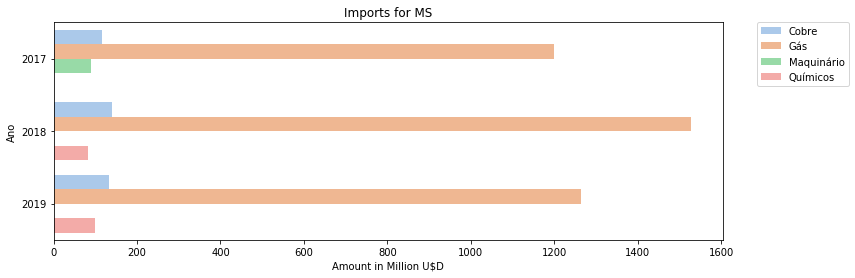

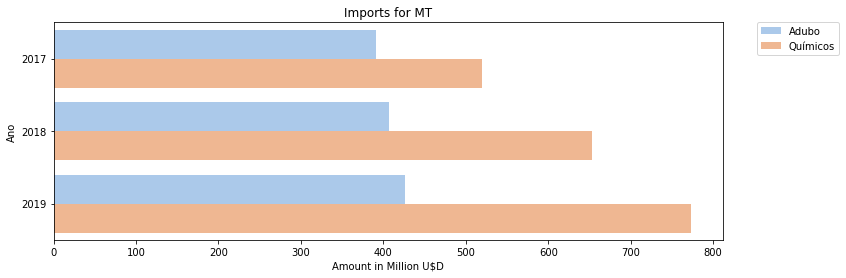

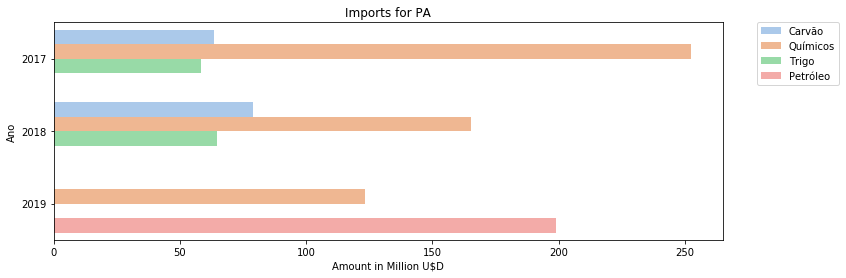

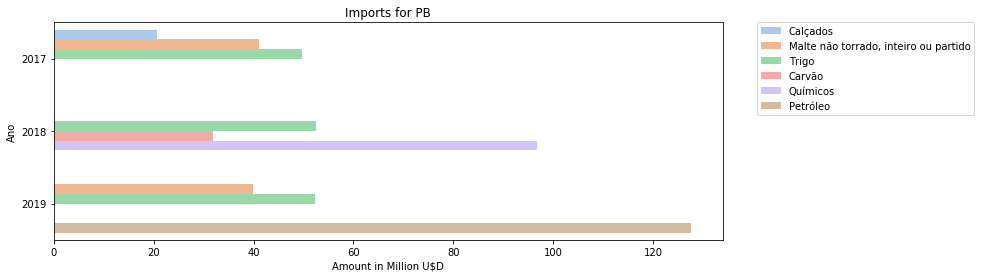

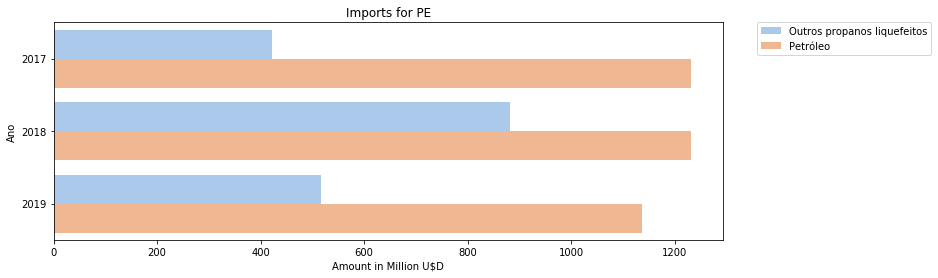

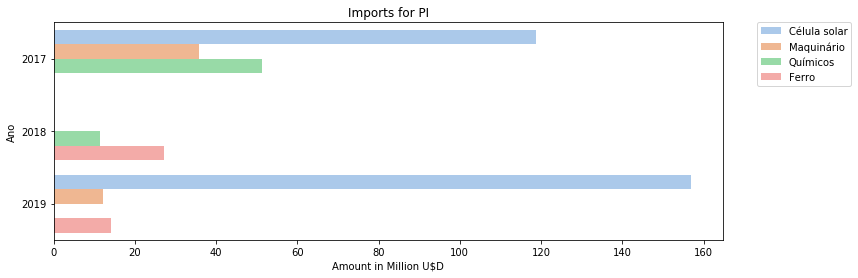

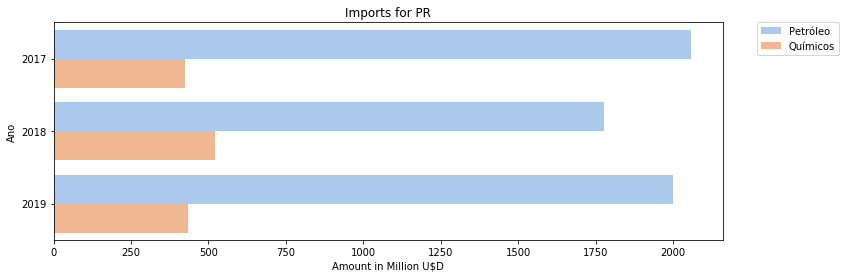

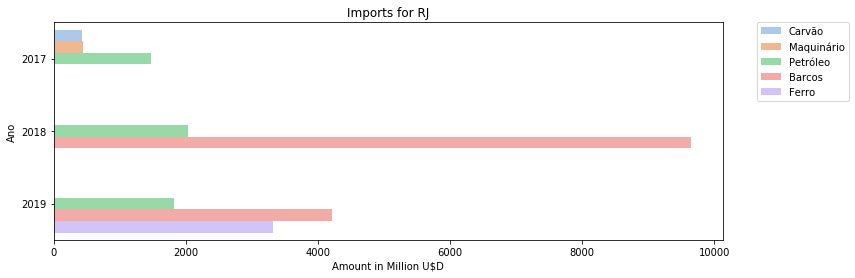

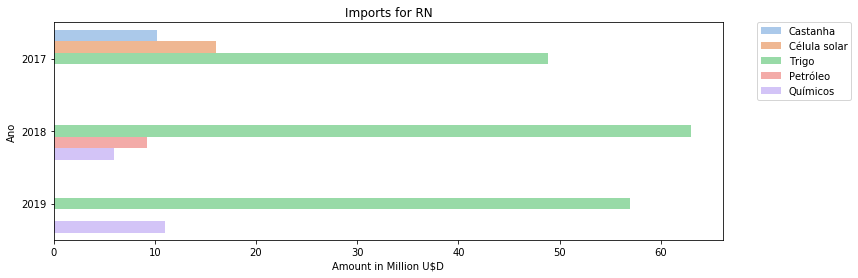

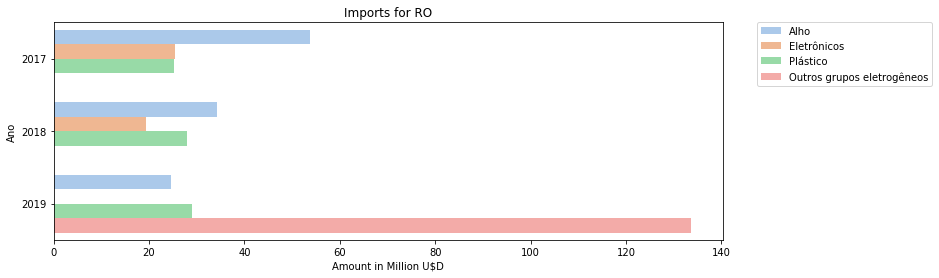

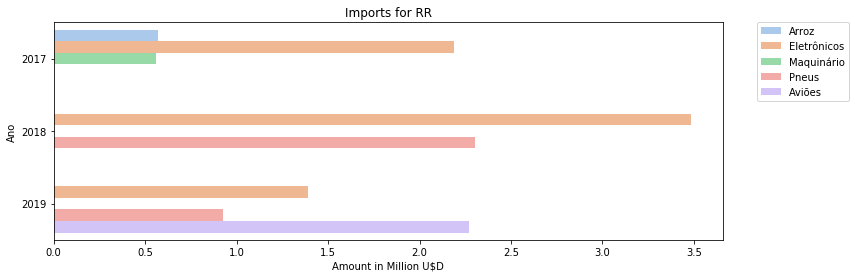

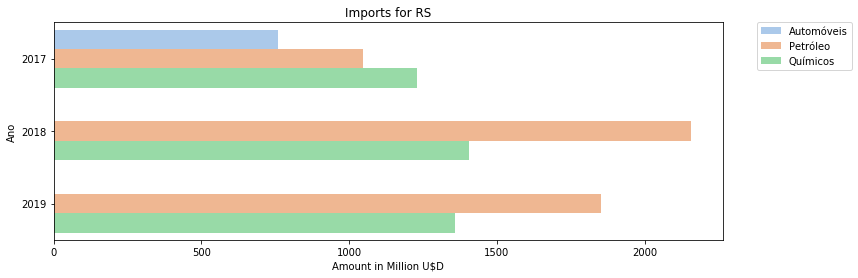

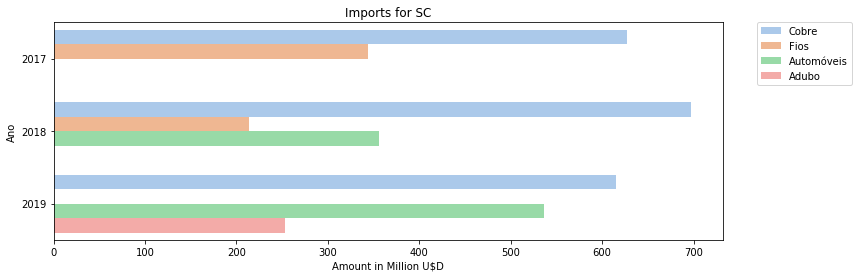

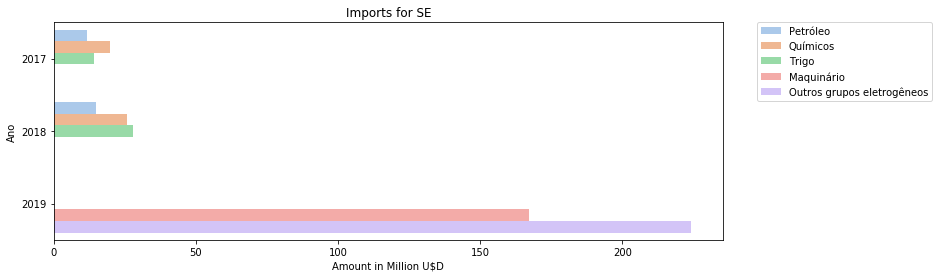

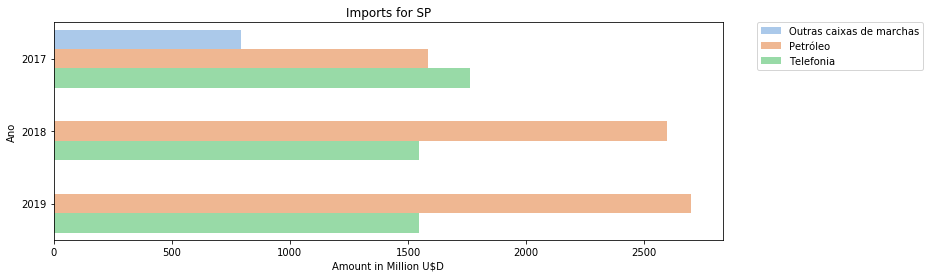

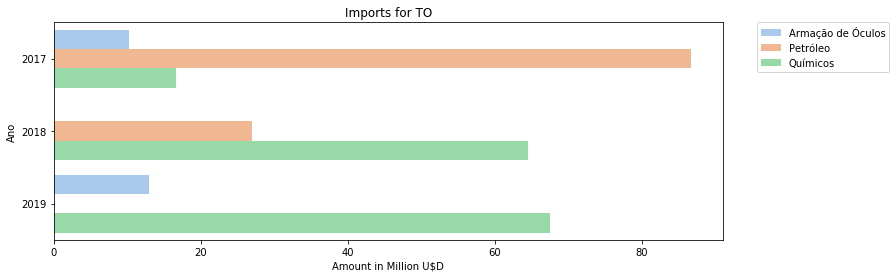

In [37]:
state_list = imp_grouped['Estado'].drop_duplicates().tolist()

for i,state in enumerate(state_list):
    fig = plt.figure(i,figsize=(12,4))
    
    ax = sns.barplot(
        x="Amount(USD)", 
        y="Ano",
        data=imp_grouped[imp_grouped['Estado']==state], 
        hue="Produto", 
        orient="h", 
        palette='pastel')
    ax.set_title('Imports for '+state)
    ax.set(xlabel='Amount in Million U$D')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('img/import_year_'+state+'.png', format='png', bbox_inches='tight', pad_inches=0.5)
    show_this = plt.show()
    plt.close(fig)


In [38]:
imp_grouped = imp_df[imp_df['Ano']==2019].groupby(['Ano','Estado'], as_index=False)['Amount(USD)'].sum()
imp_grouped.head(10)

,Ano,Estado,Amount(USD)
0,2019,AC,1957132
1,2019,AL,665943197
2,2019,AM,10163473885
3,2019,AP,126462640
4,2019,BA,6772304966
5,2019,CE,2356778510
6,2019,DF,1108620808
7,2019,ES,6274742006
8,2019,GO,3584324347
9,2019,MA,3551463014


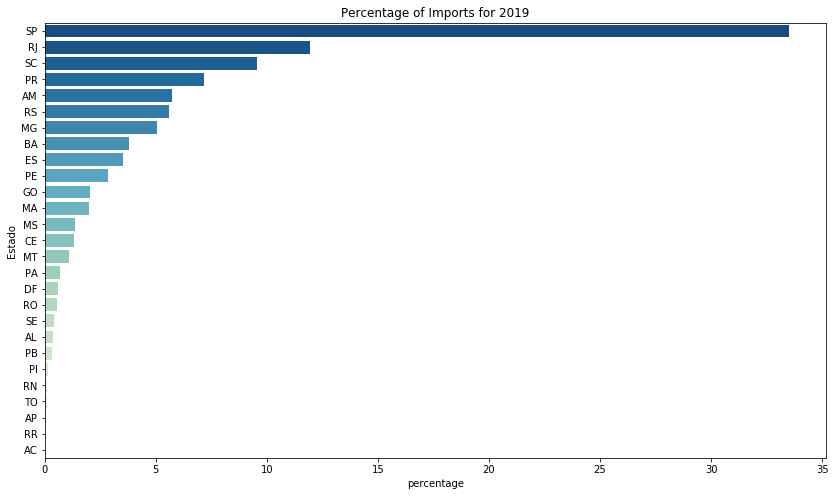

In [39]:
total_sum = imp_grouped['Amount(USD)'].sum()
imp_grouped['percentage'] = imp_grouped.apply(lambda x: (x['Amount(USD)'] / total_sum) * 100, axis=1)
imp_grouped = imp_grouped.sort_values(by='percentage',ascending=False)
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="percentage", y="Estado",data=imp_grouped, palette="GnBu_r")
ax.set_title("Percentage of Imports for 2019")
plt.savefig('img/import_percentage_2019.png', format='png', bbox_inches='tight', pad_inches=0.5)
plt.show()

## Prediction of 3 months ahead: Exports

I have downloaded two extra indexes to help in the task of prediction that have been suggested as being components of a model for prediction of exports and imports: the inflation rate and the currency of Brazilian Real against US Dolars.

Sources: 
https://br.investing.com/currencies/usd-brl-historical-data
https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=series-historicas

Another important aspect is to make a fair distinction of seasonal products (such as some agricultural commodities) and non seasonal products. In order to do this, we will plot a bar plot of top 3 products for this decade.

In [55]:
usd_df = pd.read_csv('extras/usd.csv')
usd_df[['Dia','Mes', 'Ano']] = usd_df['Data'].str.split('.', expand=True)
usd_df['Último'] = pd.to_numeric(usd_df['Último'].str.replace(',','.'))
usd_df['Mes'] = pd.to_numeric(usd_df['Mes'])
usd_grouped = usd_df[['Ano','Mes','Último']].groupby(['Ano','Mes']).mean().reset_index()
usd_grouped['Ano'] = pd.to_numeric(usd_grouped['Ano'])
usd_grouped = usd_grouped[usd_grouped['Ano']>1998]
usd_grouped['6mo_usd_avg'] = usd_grouped['Último'].rolling(6).mean()
usd_grouped['12mo_usd_avg'] = usd_grouped['Último'].rolling(12).mean()
usd_grouped = usd_grouped[usd_grouped['Ano']>2009]
usd_grouped.head(10)

,Ano,Mes,Último,6mo_usd_avg,12mo_usd_avg
179,2010,1,1.779838,1.777376,1.954895
180,2010,2,1.841395,1.776766,1.914839
181,2010,3,1.785304,1.771047,1.870777
182,2010,4,1.756391,1.773837,1.833502
183,2010,5,1.814371,1.788198,1.812446
184,2010,6,1.808336,1.797606,1.799998
185,2010,7,1.768909,1.795785,1.786580
186,2010,8,1.758768,1.782013,1.779390
187,2010,9,1.718623,1.770900,1.770974
188,2010,10,1.683514,1.758754,1.766295


In [56]:
ipca_df = pd.read_csv('extras/ipca.csv',sep=';', header=None)
ipca_df[['Mes','Ano']] = ipca_df[0].str.split(' ',expand=True)
month_list = ['janeiro',
'fevereiro',
'março',
'abril',
'maio',
'junho',
'julho',
'agosto',
'setembro',
'outubro',
'novembro',
'dezembro']
ipca_df['Mes'] = ipca_df['Mes'].apply(lambda x: month_list.index(x) + 1)
ipca_df = ipca_df[['Ano', 'Mes', 1]]
ipca_df.rename(columns={1:"ipca"}, inplace=True)
ipca_df['Ano'] = pd.to_numeric(ipca_df['Ano'])
ipca_df = ipca_df[ipca_df['Ano']>1998]
ipca_df['6mo_ipca_sum'] = ipca_df['ipca'].rolling(6).sum()
ipca_df['12mo_ipca_sum'] = ipca_df['ipca'].rolling(12).sum()
ipca_df = ipca_df[ipca_df['Ano']>2009]
ipca_df.head(10)

,Ano,Mes,ipca,6mo_ipca_sum,12mo_ipca_sum
186,2010,1,0.75,2.20,4.50
187,2010,2,0.78,2.83,4.73
188,2010,3,0.52,3.11,5.05
189,2010,4,0.57,3.40,5.14
190,2010,5,0.43,3.42,5.10
191,2010,6,0.00,3.05,4.74
192,2010,7,0.01,2.31,4.51
193,2010,8,0.04,1.57,4.40
194,2010,9,0.45,1.50,4.61
195,2010,10,0.75,1.68,5.08


In [59]:
exp_df = pd.read_csv('data/EXP_COMPLETA.csv', delimiter=';')
exp_df.query('CO_ANO > 2009', inplace=True)
exp_df.query('SG_UF_NCM == "SC"', inplace=True)
exp_df = adjust_main_df(exp_df)
exp_df = exp_df.merge(ipca_df, how='inner', on=['Ano','Mes'])
exp_df = exp_df.merge(usd_grouped, how='inner', on=['Ano','Mes'])

In [60]:

exp_df.head(10)

,Ano,Mes,Estado,Pais,Via,Produto,Kg,Amount(USD),ipca,6mo_ipca_sum,12mo_ipca_sum,Último,6mo_usd_avg,12mo_usd_avg
0,2010,12,SC,Turquia,MARITIMA,Outras impressoras com largura de impressão > ...,746,20495,0.63,2.71,5.76,1.692361,1.722386,1.759996
1,2010,12,SC,Colômbia,AEREA,Outras impressoras com largura de impressão > ...,240,9600,0.63,2.71,5.76,1.692361,1.722386,1.759996
2,2010,12,SC,Equador,AEREA,Outras impressoras com largura de impressão > ...,240,12000,0.63,2.71,5.76,1.692361,1.722386,1.759996
3,2010,12,SC,México,MARITIMA,Relés para uma tensão não superior a 60 V,3,120,0.63,2.71,5.76,1.692361,1.722386,1.759996
4,2010,12,SC,Alemanha,MARITIMA,Relés para uma tensão não superior a 60 V,112,3732,0.63,2.71,5.76,1.692361,1.722386,1.759996
5,2010,12,SC,Estados Unidos,MARITIMA,Relés para uma tensão não superior a 60 V,18,321,0.63,2.71,5.76,1.692361,1.722386,1.759996
6,2010,12,SC,Estados Unidos,MARITIMA,Relés para uma tensão não superior a 60 V,13,424,0.63,2.71,5.76,1.692361,1.722386,1.759996
7,2010,12,SC,Espanha,MARITIMA,Relés para uma tensão não superior a 60 V,55,1753,0.63,2.71,5.76,1.692361,1.722386,1.759996
8,2010,12,SC,Chile,MARITIMA,Relés para uma tensão não superior a 60 V,51,998,0.63,2.71,5.76,1.692361,1.722386,1.759996
9,2010,12,SC,Reino Unido,MARITIMA,Relés para uma tensão não superior a 60 V,116,2464,0.63,2.71,5.76,1.692361,1.722386,1.759996


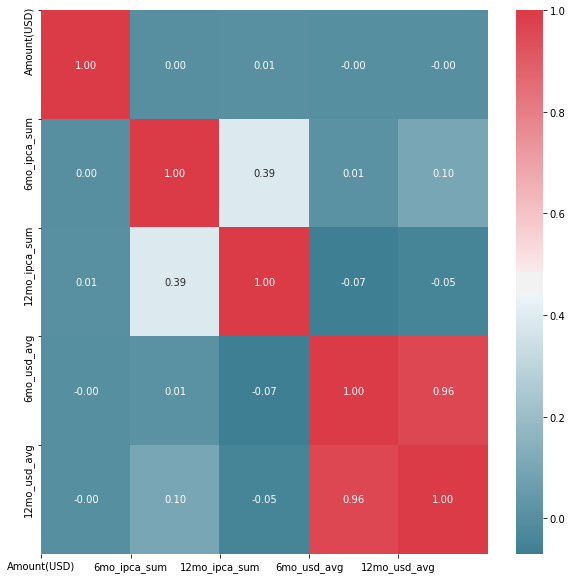

In [61]:
corr = exp_df[['Amount(USD)', '6mo_ipca_sum', '12mo_ipca_sum', '6mo_usd_avg','12mo_usd_avg' ]].corr()
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()